## Benchmarking L-BFGS solvers on the logistic regression problem

*Comparing argmin implementation with that available in scipy.optimize*

Date: April 06, 2020.

Requirements:
 - pyargmin (dev, including [pyargmin#27](https://github.com/argmin-rs/pyargmin/pull/27))
 - scipy, matplotlib
 - scikit-learn 0.22.* (we use private API)

In [3]:
import numpy as np
from numpy.testing import assert_allclose
import matplotlib.pyplot as plt

import scipy.optimize

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model._logistic import (_logistic_loss, _logistic_loss_and_grad)
from sklearn.datasets import fetch_covtype
import argmin

### 1. Load a dataset

In [4]:
X, y = fetch_covtype(return_X_y=True)

In [5]:
mask = (y == 2) | (y == 3)
X = X[mask]
y = y[mask]
y_bin = np.ones(y.shape)
y_bin[y == 2] = -1 
 
X = StandardScaler().fit_transform(X)

In [6]:
X.shape

(319055, 54)

## 2. Train Logistic Regression model with L-BFGS

Using scikit-learn's estimator,

In [7]:
%%time

est = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=500)
est.fit(X, y_bin)

CPU times: user 7.19 s, sys: 15.4 ms, total: 7.21 s
Wall time: 7.21 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

and manually via the  `scipy.optimize.minimize` funtion,

In [8]:
%%time

w0 = np.zeros(X.shape[1] + 1)

opt_res = scipy.optimize.minimize(
    _logistic_loss_and_grad,
    w0,
    method="L-BFGS-B",
    jac=True,
    args=(X, y_bin, 1.0),
    options={"gtol": 1e-4, "maxiter": 500},
)

coef = opt_res['x'][:-1]
intercept = opt_res['x'][-1]

assert_allclose(coef, est.coef_[0, :], rtol=1e-4, atol=1e-4)
assert_allclose(intercept, est.intercept_, rtol=1e-4, atol=1e-4)

CPU times: user 7.16 s, sys: 2.27 ms, total: 7.16 s
Wall time: 7.17 s


In [9]:
%%time

w0 = np.zeros(X.shape[1] + 1)

opt_res = scipy.optimize.minimize(
    _logistic_loss,
    w0,
    method="L-BFGS-B",
    jac=lambda *args, **kwargs: _logistic_loss_and_grad(*args, **kwargs)[1],
    args=(X, y_bin, 1.0),
    options={"gtol": 1e-4, "maxiter": 500},
)

coef = opt_res['x'][:-1]
intercept = opt_res['x'][-1]

assert_allclose(coef, est.coef_[0, :], rtol=1e-4, atol=1e-4)
assert_allclose(intercept, est.intercept_, rtol=1e-4, atol=1e-4)

CPU times: user 10.8 s, sys: 1.03 ms, total: 10.8 s
Wall time: 10.8 s


In [10]:
%%time

class LogisticLoss:
    def __init__(self, X, y, alpha=1.0):
        self.X = X
        self.y = y
        self.alpha = alpha

    def apply(self, w):
        cost = _logistic_loss(w, self.X, self.y, self.alpha)
        return cost

    def gradient(self, w):
        _, grad = _logistic_loss_and_grad(w, self.X, self.y, self.alpha)
        return grad
    
    
loss = LogisticLoss(X, y_bin)
loss.gradient(w0)

solver = argmin.lbfgs(m=10, tol_grad=1e-5)

executor = argmin.executor(loss, solver, w0, max_iter=500)
x_opt = executor.run()

CPU times: user 42.1 s, sys: 96.7 ms, total: 42.2 s
Wall time: 42 s


In [16]:
assert_allclose(x_opt[:-1], est.coef_[0, :], rtol=2e-2, atol=2e-2)

AssertionError: 
Not equal to tolerance rtol=0.02, atol=0.02

Mismatched elements: 6 / 54 (11.1%)
Max absolute difference: 0.15058643
Max relative difference: 6.83202872
 x: array([-4.097064e+00,  2.034346e-01, -3.002162e-01,  1.029803e+00,
        6.069836e-02,  8.965370e-01, -9.269159e-01,  8.329707e-01,
       -1.572041e+00, -6.943207e-02, -1.530025e+00, -5.625123e-02,...
 y: array([-4.096513e+00,  2.032744e-01, -3.004393e-01,  1.029694e+00,
        6.068366e-02,  8.962305e-01, -9.266363e-01,  8.323696e-01,
       -1.571307e+00, -7.003769e-02, -1.517910e+00,  9.433520e-02,...

## Evaluating convergence

In [17]:
w0 = np.zeros(X.shape[1] + 1)

loss_hist = []
grad_hist = []

def callback(w):
    cost, grad = _logistic_loss_and_grad(w, X, y_bin, 1.0)
    loss_hist.append(cost)
    grad_hist.append(np.linalg.norm(grad, ord=2))
    

opt_res = scipy.optimize.minimize(
    _logistic_loss,
    w0,
    method="L-BFGS-B",
    jac=lambda *args, **kwargs: _logistic_loss_and_grad(*args, **kwargs)[1],
    args=(X, y_bin, 1.0),
    options={"gtol": 1e-4, "maxiter": 500},
    callback=callback
)

Text(0, 0.5, 'L2 gradient norm')

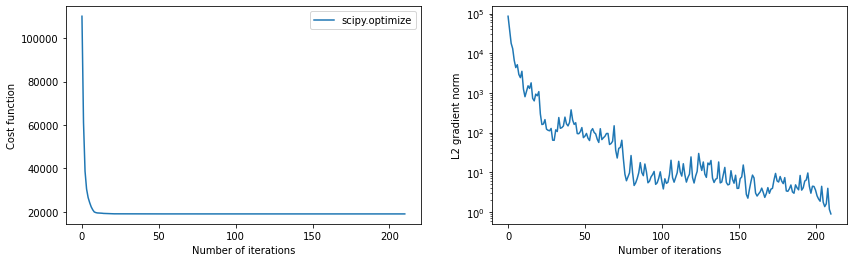

In [18]:
fig, ax = plt.subplots(1, 2,figsize=(14, 4))

ax[0].plot(loss_hist, label='scipy.optimize')

ax[1].plot(grad_hist)
ax[1].set_yscale('log')
ax[0].legend()

for axi in ax:
    axi.set_xlabel('Number of iterations')
ax[0].set_ylabel('Cost function')
ax[1].set_ylabel('L2 gradient norm')

In [19]:
np.sqrt(2.2204460492503131E-16)

1.4901161193847656e-08